<font size=20> Template Matching

In [103]:
from __future__ import print_function
import sys
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from concurrent.futures import ThreadPoolExecutor, as_completed

os.chdir("/usr/src/app")

In [245]:
def path_video(video_id):
    return f'videos/{video_id}.mp4'

def capture_frame(video_path, frame_num):
    cap = get_video(video_path)
    frame = get_frame(cap, frame_num)
    return cap, frame

def get_video(video_path):
    return cv2.VideoCapture(video_path)

def get_frame(cap, frame_num):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    
    # Read the frame
    ret, frame = cap.read()

    return frame


def get_fps_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Release the video capture object
    cap.release()

    return fps

def plot_frames_grid(frames, nrows, ncols, size=(14, 11)):
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=size)
    
    # Add content to each subplot (replace this with your data)
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            frame = frames[idx]
            ax = axes[i, j]
            ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            idx += 1
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()


def plot_frame(frame, size=(14,11)):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=size)
    
    # Display the frame
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return fig, ax

def plot_net(ax, net_points, frame):
    # Draw the net (rectangle) on the frame in green
    net_points = np.array(net_points, dtype=int)
    cv2.polylines(frame, [net_points], isClosed=True, color=(0, 255, 0), thickness=2)
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return ax

def plot_court(ax, court_points):
    # Extract court points and scatter them as black points
    court_points = np.array(court_points, dtype=int)
    ax.scatter(court_points[:, 0], court_points[:, 1], c='black', s=5)
    return ax

def get_patch(image, court_points, idx, w = 25):
    kp = court_points[idx]
    x,y = kp
    x = int(x); y = int(y)
    patch = image[y-w:y+w, x-w:x+w, :]
    return patch

def patch_image(image, center, w=(25, 25)):
    x,y = center
    wx, wy = w
    x = int(x); y = int(y)
    patch = image[y-wy:y+wy, x-wx:x+wx, :]
    return patch

def match_patch(img, patch, window_template, loc_at_center=True):
    # Template matching
    match_method = cv2.TM_SQDIFF
    result = cv2.matchTemplate(img, patch, match_method)

    # Find the minimum value (best match) and its location
    # this is the top left corner of the box
    min_val, _, min_loc, _ = cv2.minMaxLoc(result)
    
    # Subtract the width to all tuple elements since we convert
    # top left into the center of the patch
    if loc_at_center:
        match_loc = op_tuples(min_loc, window_template)
    else:
        match_loc = min_loc
    
    return match_loc

def wrap_match_patch(img, patch, ii):
    return match_patch(img, patch), ii

def eval_match_patch(match_loc, true_loc):
    # Convert the float target center of the patch into integers
    true_loc = tuple(map(lambda x: int(x), true_loc))
    return mse(true_loc, match_loc)

def match_all_patches(img, patches):
    d_match_loc = {}
    with ThreadPoolExecutor(len(patches)) as executor:
        pool_res = [executor.submit(wrap_match_patch, img, patch, idx_patch) for idx_patch, patch in enumerate(patches)]
        for future_res in as_completed(pool_res):
            res_match_patch, idx_patch = future_res.result()
            d_match_loc[idx_patch] = res_match_patch
    return d_match_loc

def op_tuples(tuple1, tuple2, op="add"):
    if op == "add":
        result = tuple(x + y for x, y in zip(tuple1, tuple2))
    elif op == "subtract":
        result = tuple(x - y for x, y in zip(tuple1, tuple2))
    else:
        result = None
    return result

def draw_circle(img, pos):
    x_img = img.copy()
    color = (0, 0, 255)
    size = 10
    x_img = cv2.circle(x_img, pos, size, color, -1)
    plot_frame(x_img, size=(8,3))

# Read annotations

In [105]:
PATH_ANNOTATIONS_REFERENCE_PARQUET = "annotations/reference_courts/annotations.parquet"
dfannot = pd.read_parquet(PATH_ANNOTATIONS_REFERENCE_PARQUET, engine="pyarrow")

# Select Reference court

In [107]:
tournament_id = 4  # Indian Wells

In [124]:
# Get the reference court points and net points at the given frame number
series = dfannot[dfannot["tournament_id"] == tournament_id].reset_index(drop=True).T.to_dict()

In [172]:
d_annot = series[0]
video_id = d_annot["video_id"]  # "DhnpBjrgb34"
frame_num = d_annot["frame_id"]
court_points = np.vstack(d_annot["court"])
net_points = np.vstack(d_annot["net"])
path = path_video(video_id)

print(f"Video: {video_id}, Frame: {frame_num}, Path: {path}")

Video: fnK4I6k9eHs, Frame: 29533, Path: videos/fnK4I6k9eHs.mp4


### Load frame of reference court

In [159]:
# Load reference frame
_, t_img = capture_frame(path, frame_num)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

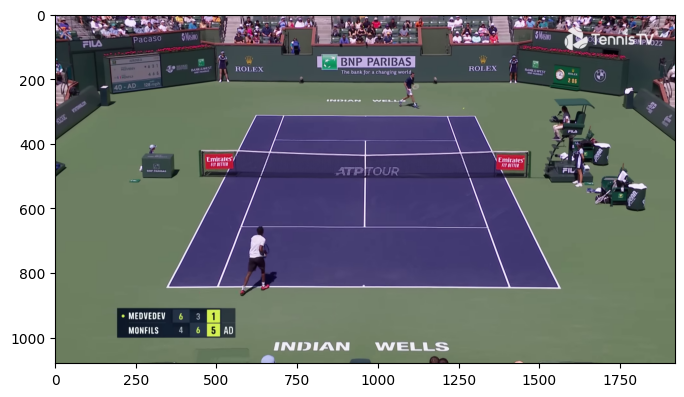

In [160]:
plot_frame(t_img, size=(8,8))

# Select Query court

In [155]:
q_video_id = "jGAMZKj6Ceo"
q_path = path_video(q_video_id)
q_fps = get_fps_video(q_path)
q_second = 37.8
q_frame_num = int(q_second * q_fps)

In [156]:
# Load reference frame
_, q_img = capture_frame(q_path, q_frame_num)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

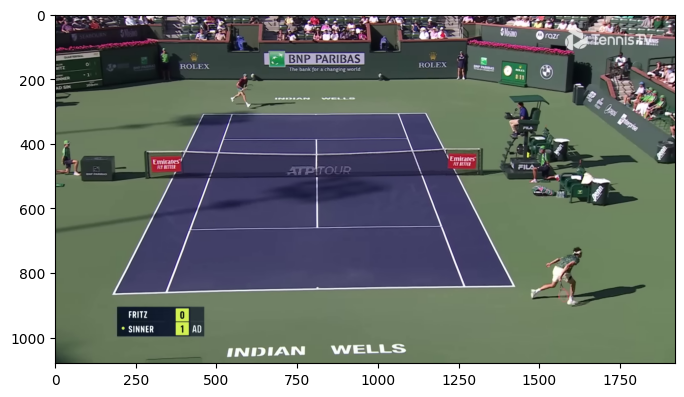

In [158]:
plot_frame(q_img, size=(8,8))

In [228]:
q_img.shape

(1080, 1920, 3)

## Visualize patches

### Reference court

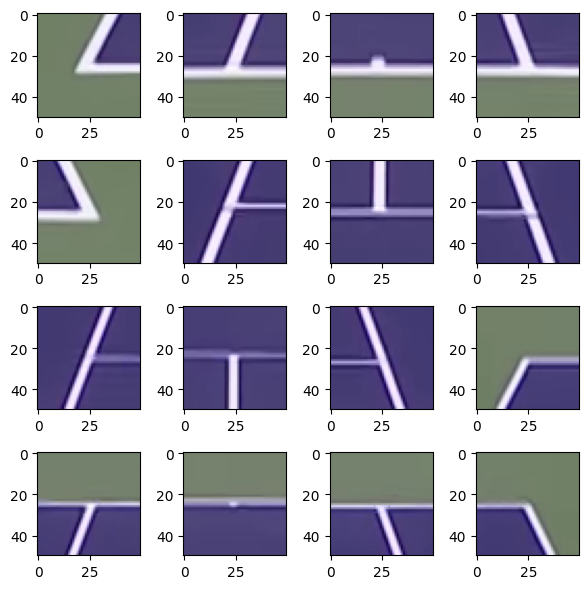

In [180]:
w = 25
t_patches = [get_patch(t_img, court_points, ii, w) for ii in range(len(court_points))]
plot_frames_grid(t_patches, 4, 4, size=(6, 6))

### Query court (patching on the reference court corners x,y)

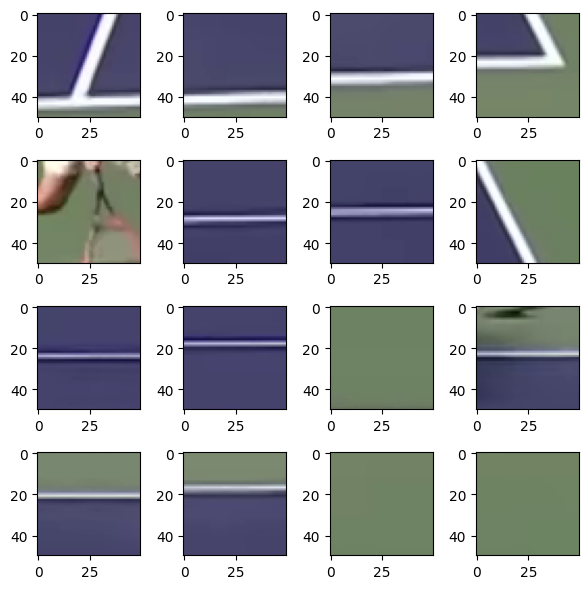

In [181]:
w = 25
q_patches = [get_patch(q_img, court_points, ii, w) for ii in range(len(court_points))]
plot_frames_grid(q_patches, 4, 4, size=(6, 6))

# [SOLUTION] Patch Query image larger and find match with reference court patch

(<Figure size 800x300 with 1 Axes>, <Axes: >)

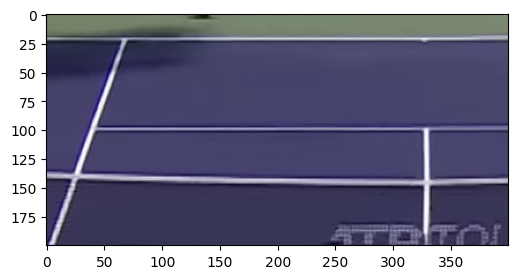

In [260]:
# Patch query image larger in each reference court position
corner_id = 8

# Center of the point of one of the 16 corners
center_ref = court_points[corner_id]

# Patch of the query image
wq_img = (200,100)
pq_img = patch_image(q_img, center_ref, w=w_img)
plot_frame(pq_img, size=(8,3))

In [261]:
# Patch of Reference court template
wt_img = (18, 18)
pt_img = patch_image(t_img, court_points[corner_id], wt_img)

(<Figure size 800x300 with 1 Axes>, <Axes: >)

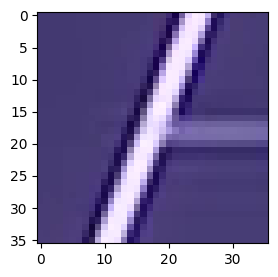

In [262]:
plot_frame(pt_img, size=(8,3))

### Find match of the reference patch OVER the query patch of that corner

In [263]:
%%time
# ---------------------- #
#     Windows
# ---------------------- #
wq_img = (200,100)  # window of query image
wt_img = (18, 18)   # window of the reference court corner

# Patch of the query image
pq_img = patch_image(q_img, center_ref, w=wq_img)

# Patch of the reference (template) image
pt_img = patch_image(t_img, center_ref, wt_img)

# Match patch (coordinates relative to the patch of the query image)
relative_match_loc = np.array(match_patch(pq_img, pt_img, wt_img))

# Match abs loc
abs_match_loc = ((relative_match_loc + center_ref) - wq_img).astype(int)

CPU times: user 6.98 ms, sys: 163 µs, total: 7.14 ms
Wall time: 5.29 ms


In [264]:
relative_match_loc

array([50, 73])

In [265]:
abs_match_loc.astype(int)

array([530, 362])

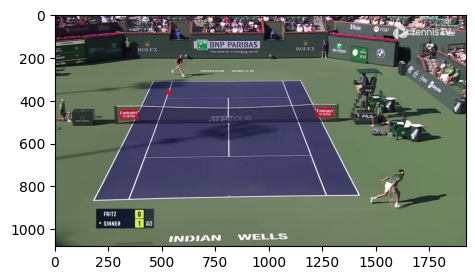

In [266]:
draw_circle(q_img, pos = abs_match_loc)

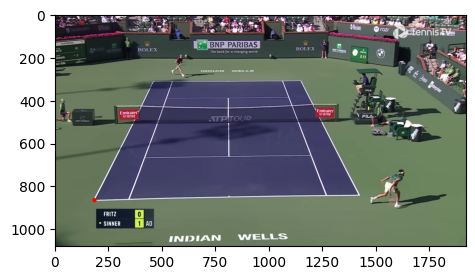

In [258]:
draw_circle(q_img, pos = abs_match_loc)

(<Figure size 1400x1100 with 1 Axes>, <Axes: >)

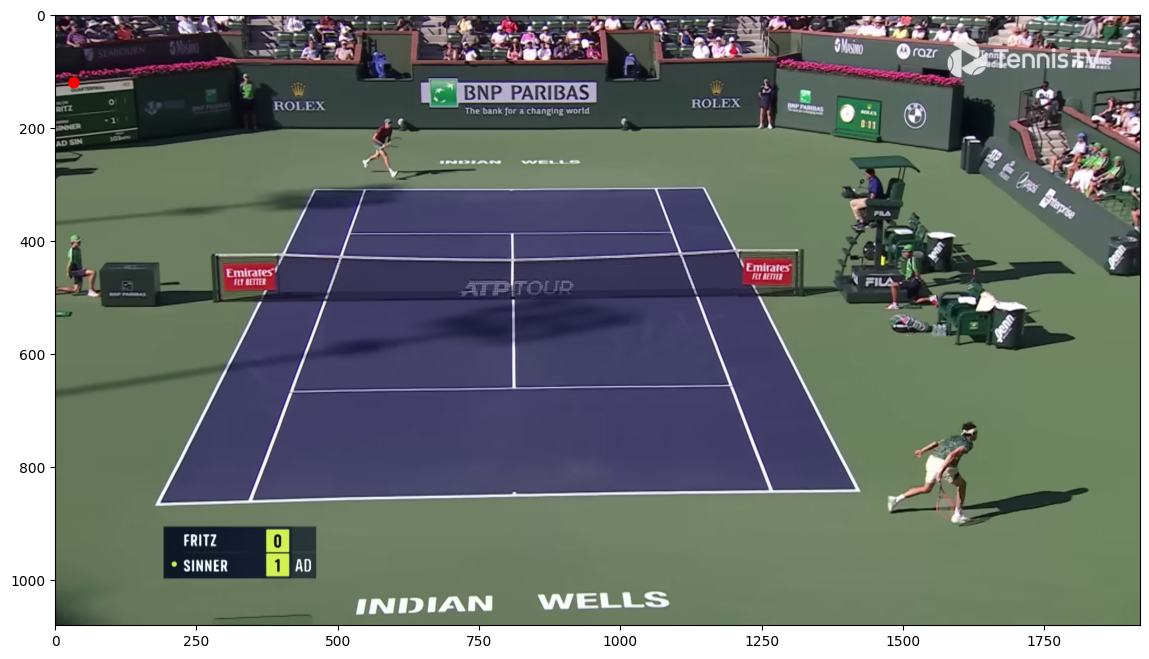

In [240]:
# Plot result
x_img = q_img.copy()
image_with_point = cv2.circle(x_img, abs_match_loc, 10, (0, 0, 255), -1)
plot_frame(image_with_point)

In [235]:
center_ref

array([351. , 844.7])

In [236]:
relative_match_loc

array([ 33, 121])

array([184. , 865.7])

In [ ]:
# Get the global coordinates in the entire image
absolute_match_loc = tuple(int(abs_loc - (rel_loc - rel_match_loc)) for abs_loc, rel_loc, rel_match_loc  in zip(center_ref, window, relative_match_loc))

(<Figure size 1400x1100 with 1 Axes>, <Axes: >)

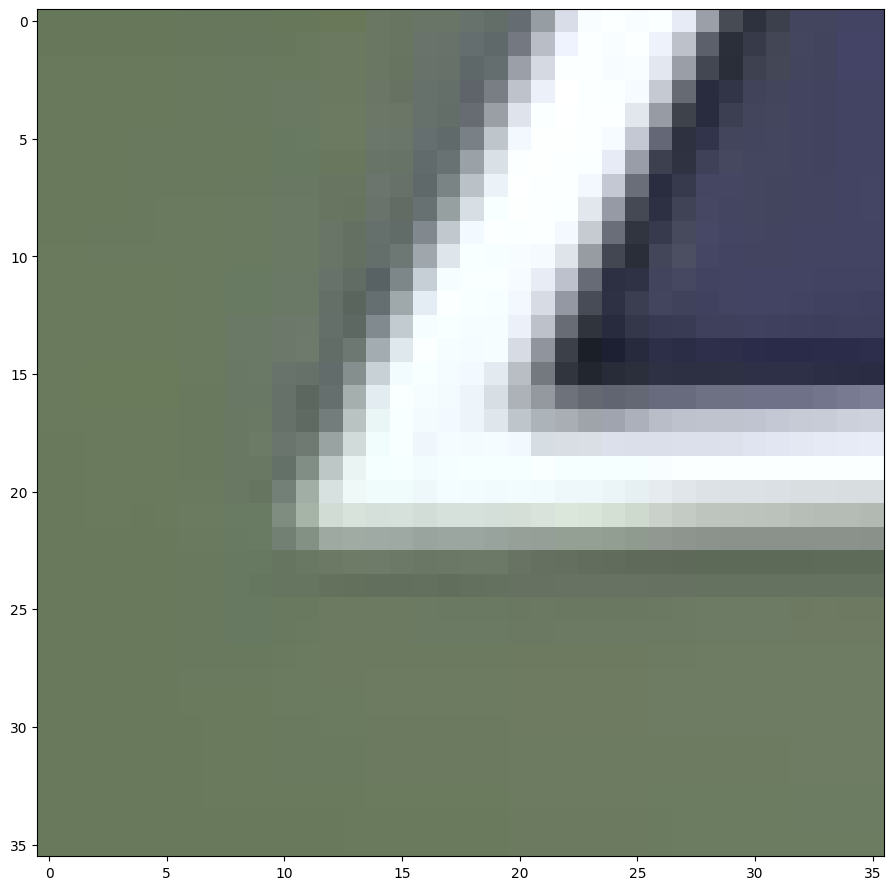

In [211]:
xx = patch_image(pq_img, relative_match_loc, wt_img)
plot_frame(xx)

In [ ]:
# Convert relative coordinates to global coordinates of the entire query image


In [208]:
relative_match_loc

(33, 121)

In [ ]:




# Get the global coordinates in the entire image
absolute_match_loc = tuple(int(abs_loc - (rel_loc - rel_match_loc)) for abs_loc, rel_loc, rel_match_loc  in zip(center_ref, window, relative_match_loc))

# Error
err_match = eval_match_patch(absolute_match_loc, center_ref)

# Plot
plot_frame(p1_img, size=(8,3))
plot_frame(p1_ref, size=(8,3))f

# APPENDIX

# Match Query corners to Reference court Corners

In [239]:
d_corners = {}
d_min_vals = {}

In [240]:
# ---------------------- #
#     Windows
# ---------------------- #
wq_img = (200,40)  # window of query image
wt_img = (18, 18)   # window of the reference court corner

In [227]:
%%time
for corner_id, center_ref in enumerate(court_points):
    # corner_id: ID of the corner of the court
    # center_ref: (x,y) center of the point of one of the 16 corners
    
    # Patch of the query image
    pq_img = patch_image(q_img, center_ref, w=wq_img)
    
    # Patch of the reference (template) image
    pt_img = patch_image(t_img, center_ref, w=wt_img)

    # Match patch (coordinates relative to the patch of the query image)
    relative_match_loc, min_val = match_patch(pq_img, pt_img, wt_img)
    relative_match_loc = np.array(relative_match_loc)
    
    # Match abs loc
    abs_match_loc = ((relative_match_loc + center_ref) - wq_img).astype(int)
    d_corners[corner_id] = abs_match_loc
    d_min_vals[corner_id] = min_val

CPU times: user 29.8 ms, sys: 26 µs, total: 29.8 ms
Wall time: 28.1 ms


# Plot Matched corners frame

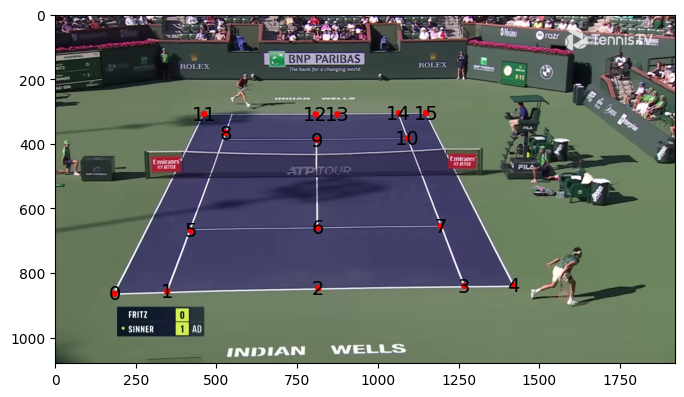

In [228]:
xx_img = q_img.copy()
for corner_id, corner_loc in d_corners.items():
    xx_img = draw_circle(xx_img, corner_loc, plot=False)
fig, ax = plot_frame(xx_img, size=(8,8))

for corner_id, corner_loc in d_corners.items():
    ax.annotate(str(corner_id), corner_loc, va='center', ha='center', fontsize=14)

In [229]:
np.array(list(d_min_vals.values())) / 1_000_000

array([0.734295, 0.987493, 0.600477, 1.080054, 0.523919, 1.294258,
       0.837977, 1.009967, 1.443243, 0.795283, 1.065083, 2.850275,
       4.402089, 0.391769, 0.648712, 0.680004])

In [230]:
d_min_vals = {k: v/1_000_000 for k,v in d_min_vals.items()}

In [231]:
d_min_vals

{0: 0.734295,
 1: 0.987493,
 2: 0.600477,
 3: 1.080054,
 4: 0.523919,
 5: 1.294258,
 6: 0.837977,
 7: 1.009967,
 8: 1.443243,
 9: 0.795283,
 10: 1.065083,
 11: 2.850275,
 12: 4.402089,
 13: 0.391769,
 14: 0.648712,
 15: 0.680004}

# Image Similarity

In [232]:
import torch
from transformers import (
    CLIPProcessor,
    CLIPModel,
)
from torch.nn import CosineSimilarity
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.nn import CosineEmbeddingLoss

In [233]:
# Load the CLIP model
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

In [ ]:
# Embedding of the ref image
ref_images = [from_bgr_to_pil(i_img) for i_img in [t_img]]
ref_inputs = processor(images=ref_images, return_tensors="pt", padding=True)

In [234]:
def compute_img_similarity(img1, img2, model=model, processor=processor):
    # Convert from RGB output of CV2 to PIL image format
    images = [from_bgr_to_pil(i_img) for i_img in [img1, img2]]

    # Preprocess to enter VIT requirements
    inputs = processor(images=images, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    
    cos = CosineSimilarity(dim=0, eps=1e-6)
    return cos(outputs[0], outputs[1])

In [241]:
compute_img_similarity(q_img, t_img)

tensor(0.8639)

In [39]:
ex1 = 1000 # not match
ex2 = 1150  # perfect match
ex3 = 3500


_, img = capture_frame(path, frame_num + ex2)

In [40]:
court_points

[(374.6, 757.1),
 (524.2, 756.6),
 (965.7, 757.7),
 (1408.1, 754.9),
 (1563.7, 757.4),
 (623.9, 537.9),
 (966.0, 539.4),
 (1313.9, 535.4),
 (743.0, 272.9),
 (968.3, 271.9),
 (1197.6, 272.8),
 (702.4, 207.8),
 (771.4, 205.4),
 (970.2, 207.3),
 (1171.1, 205.0),
 (1239.1, 205.3)]

(<Figure size 800x800 with 1 Axes>, <Axes: >)

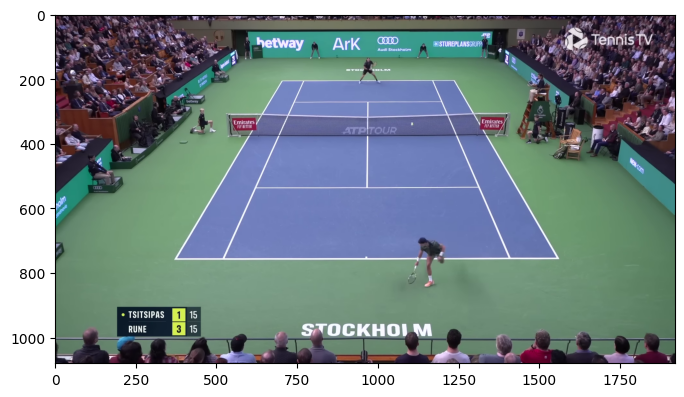

In [54]:
plot_frame(template, size=(8,8))

(<Figure size 800x300 with 1 Axes>, <Axes: >)

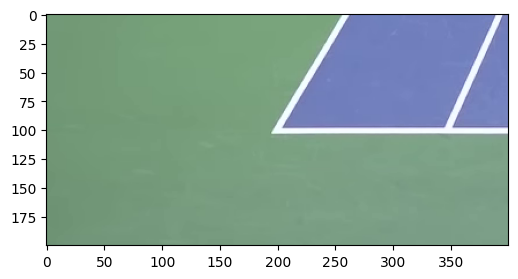

In [53]:
# Try a patch that considers camera sliding laterally
p1 = patch_image(template, (374.6, 757.1), w=(200, 100))
plot_frame(p1, size=(8,3))

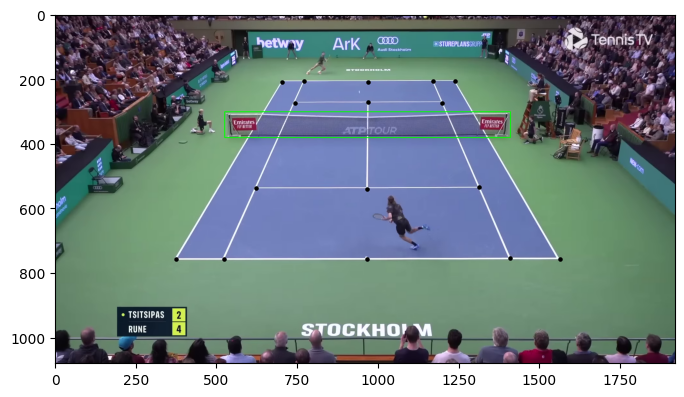

In [55]:
frame = img

# PLot frame
fig, ax = plot_frame(frame, size=(8,8))

# Plot net
ax = plot_net(ax, net_points, frame)

# Plot court
ax = plot_court(ax, court_points)

# Show the plot
plt.show()

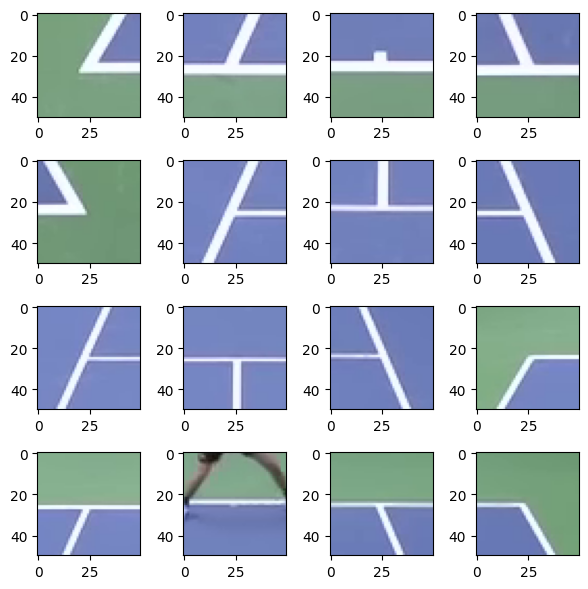

In [56]:
w = 25
patches_template = [get_patch(template, court_points, ii, w) for ii in range(len(court_points))]
plot_frames_grid(patches_template, 4, 4, size=(6, 6))

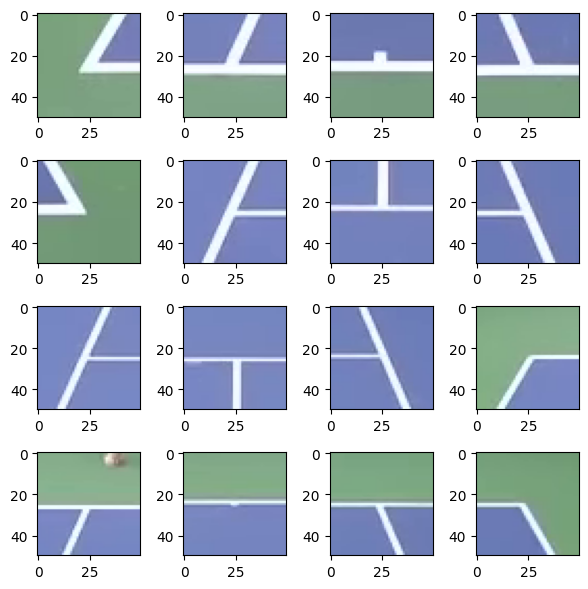

In [57]:
w = 25
patches_img = [get_patch(img, court_points, ii, w) for ii in range(len(court_points))]
plot_frames_grid(patches_img, 4, 4, size=(6, 6))

In [59]:
def match_patch(img, patch):
    # Template matching
    match_method = cv2.TM_SQDIFF
    result = cv2.matchTemplate(img, patch, match_method)

    # Find the minimum value (best match) and its location
    # this is the top left corner of the box
    min_val, _, min_loc, _ = cv2.minMaxLoc(result)
    
    # Subtract the width to all tuple elements since we convert
    # top left into the center of the patch
    match_loc = tuple(map(lambda x: x + w, min_loc))
    
    return match_loc

def wrap_match_patch(img, patch, ii):
    return match_patch(img, patch), ii

def eval_match_patch(match_loc, true_loc):
    # Convert the float target center of the patch into integers
    true_loc = tuple(map(lambda x: int(x), true_loc))
    return mse(true_loc, match_loc)

def match_all_patches(img, patches):
    d_match_loc = {}
    with ThreadPoolExecutor(len(patches)) as executor:
        pool_res = [executor.submit(wrap_match_patch, img, patch, idx_patch) for idx_patch, patch in enumerate(patches)]
        for future_res in as_completed(pool_res):
            res_match_patch, idx_patch = future_res.result()
            d_match_loc[idx_patch] = res_match_patch
    return d_match_loc

### Match a single patch

(<Figure size 800x300 with 1 Axes>, <Axes: >)

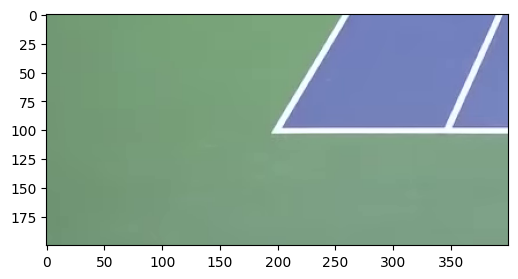

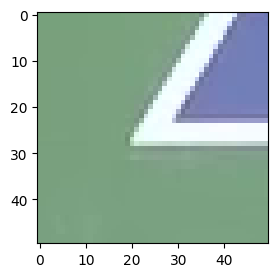

In [99]:
# Center of the point of one of the 16 corners
center_ref = court_points[0]

# Patch of the query image
w_img = (200,100)
p1_img = patch_image(img, center_ref, w=w_img)

# Patch of the reference image
w_ref = (25, 25)
p1_ref = patch_image(template, center_ref, w=w_ref)

# Match patch
relative_match_loc = match_patch(p1_img, p1_ref)

# Get the global coordinates in the entire image
absolute_match_loc = tuple(int(abs_loc - (rel_loc - rel_match_loc)) for abs_loc, rel_loc, rel_match_loc  in zip(center_ref, window, relative_match_loc))

# Error
err_match = eval_match_patch(absolute_match_loc, center_ref)

# Plot
plot_frame(p1_img, size=(8,3))
plot_frame(p1_ref, size=(8,3))

In [145]:
# Get patches


# Parallelize all patches

In [146]:
%%time
# Match all patches to a location
w = 25
patches = [get_patch(template, court_points, ii, w) for ii in range(len(court_points))]
res = match_all_patches(img, patches)

CPU times: user 1.94 s, sys: 1.5 s, total: 3.44 s
Wall time: 1.06 s


In [147]:
res

{0: (1702, 991),
 2: (1316, 677),
 1: (1709, 991),
 8: (1316, 676),
 7: (1317, 676),
 3: (1317, 675),
 5: (1316, 676),
 6: (1316, 677),
 4: (1318, 683),
 14: (1316, 677),
 9: (1316, 676),
 10: (1316, 674),
 13: (1317, 658),
 15: (1316, 675),
 12: (1316, 677),
 11: (1316, 677)}

In [148]:
%%time
errs = [eval_match_patch(res[ii], court_points[ii]) for ii in range(len(court_points))]

CPU times: user 3.9 ms, sys: 2.03 ms, total: 5.93 ms
Wall time: 5.15 ms


In [149]:
errs

[909170.0,
 729725.0,
 64800.5,
 7261.0,
 32750.5,
 249785.0,
 70772.0,
 9948.5,
 245772.5,
 142564.5,
 87882.5,
 298948.0,
 259904.5,
 161905.0,
 121904.5,
 113414.5]

# Edge Case

In [58]:
video_id = "jGAMZKj6Ceo" 